In [15]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib import *
from model import SSD
import torch

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
cfg = {
    "num_classes": 21, #VOC data include 20 class + 1 background class
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
}

net = SSD('inference', cfg)    # initialize SSD
# net_weights = torch.load('./data/weights/ssd300_mAP_77.43_v2.pth', map_location={'cuda:0': 'cpu'})
net_weights = torch.load('./data/weights/ssd300_50.pth', map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)
net = net.to(device)

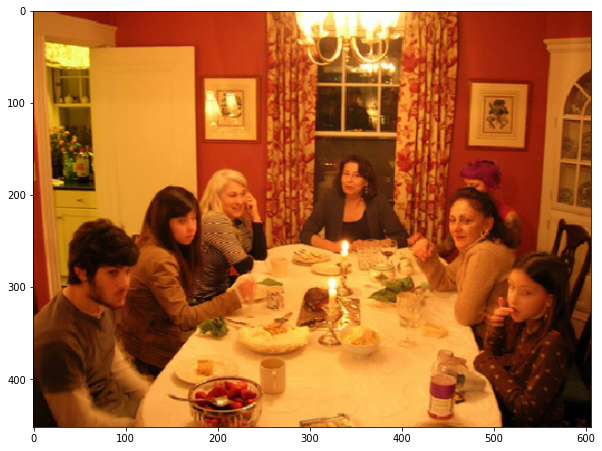

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
from transform import DataTransform

# image_file_path = "./data/cowboy-757575_640.jpg"
image_file_path = "./data/people_party.png"
image = cv2.imread(image_file_path) # [ 高さ ][ 幅 ][ 色 BGR]
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

In [34]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


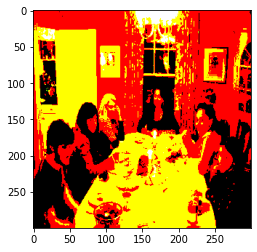

In [35]:
# from show_result import SSDPredictShow

# ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
# ssd.show(image_file_path, data_confidence_level=0.6)

x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [36]:
xx = x.unsqueeze(0)     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.to(device)
y = net(xx)

In [37]:
labels = ['aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor']

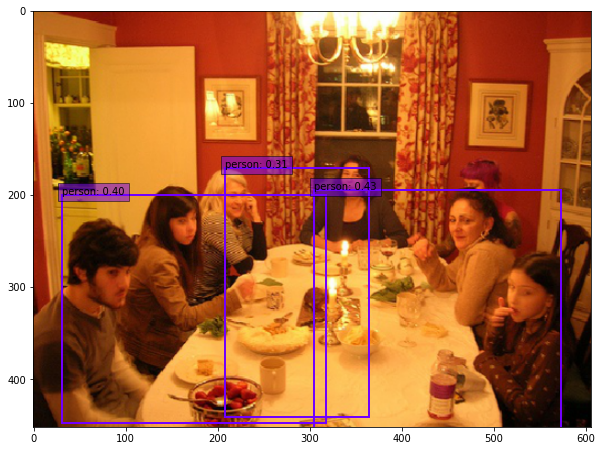

In [39]:
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.3:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

